In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import sklearn

In [2]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [4]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2,10)
        self.layer_2 = nn.Linear(10,10)
        self.layer_3 = nn.Linear(10,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model = CircleModel().to(device)

In [5]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred)
    correct_count = correct.sum().item()
    acc = (correct_count / len(y_pred)) * 100    
    return acc

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))

        test_loss = loss_fn(y_test_logits, y_test)
        acc_test = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Test Loss{test_loss:.4f}  Accuracy: {acc:.2f}% | Test Accuracy{acc_test:.2f}%" )

Epoch 100 | Loss: 0.6911 | Test Loss0.6897  Accuracy: 51.88% | Test Accuracy52.50%
Epoch 200 | Loss: 0.6893 | Test Loss0.6875  Accuracy: 52.12% | Test Accuracy52.00%
Epoch 300 | Loss: 0.6869 | Test Loss0.6847  Accuracy: 52.25% | Test Accuracy53.50%
Epoch 400 | Loss: 0.6838 | Test Loss0.6809  Accuracy: 53.75% | Test Accuracy53.50%
Epoch 500 | Loss: 0.6793 | Test Loss0.6757  Accuracy: 63.00% | Test Accuracy61.00%
Epoch 600 | Loss: 0.6721 | Test Loss0.6680  Accuracy: 66.62% | Test Accuracy65.00%
Epoch 700 | Loss: 0.6595 | Test Loss0.6552  Accuracy: 72.50% | Test Accuracy72.50%
Epoch 800 | Loss: 0.6348 | Test Loss0.6326  Accuracy: 82.12% | Test Accuracy82.50%
Epoch 900 | Loss: 0.5856 | Test Loss0.5905  Accuracy: 89.62% | Test Accuracy87.50%
Epoch 1000 | Loss: 0.4993 | Test Loss0.5118  Accuracy: 93.12% | Test Accuracy90.00%


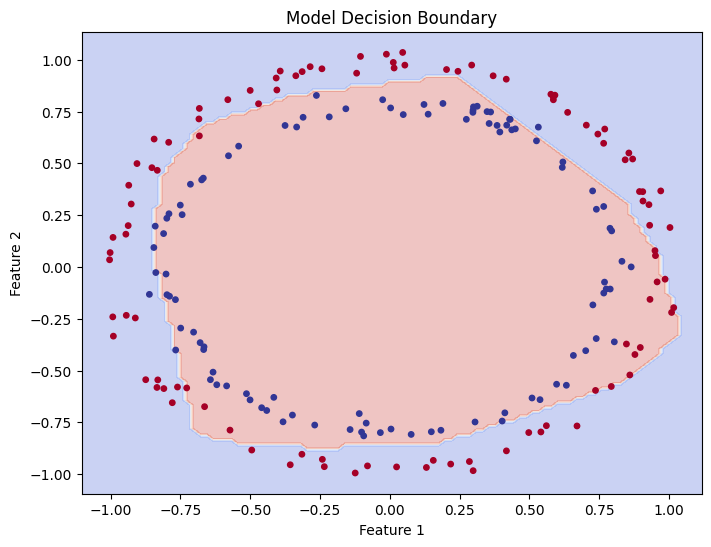

In [7]:
# Import necessary
import numpy as np

def plot_decision_boundary(model, X, y):
    model.eval()
    X, y = X.cpu(), y.cpu()
    
    # Create a mesh of points
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Make predictions on the mesh
    X_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)
    with torch.inference_mode():
        logits = model(X_mesh).squeeze()
        y_pred = torch.sigmoid(logits)
        y_class = (y_pred > 0.5).float()
    y_class = y_class.cpu().numpy().reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, y_class, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, s=15)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Model Decision Boundary")
    plt.show()

# Call the function
plot_decision_boundary(model, X_test, y_test)